# Observing Etna Eruption
<small><i>This use case was prepared with support from European Space Agency.</i></small>


## 1 Introduction 
In early spring 2017, biggest Sicilian volcano - Etna - awakened and erupted several times. The Etna eruption started on January 23rd 2017 but intensified after February 27th and the activity continued till late April.
<br>
<figure>
    <img src='https://3c1703fe8d.site.internapcdn.net/newman/gfx/news/hires/2017/2-10injuredine.jpg' width='600' height='600' />
    <figcaption style="text-align:center">Etna eruption on March 16th 2017 (source:<a href="https://phys.org/news/2017-03-explosion-erupting-mount-etna-volcano.html"> phys.org</a>).</figcaption>
</figure>
<br>

In this exercise we will demonstrate how such events can be observed using satellite images. We will utilize imagery acquired from satellites Sentinel 2 (s2) and Landsat 8 (l8). We will introduce the basic physical concepts that we need in order to understand the example but we will not go into theoretical details.

First, we need to set up two "technical" things:

1) The text and code you see here are written in Jupyter Notebook. You will need to "execute cells" to see satellite images. You can do that by clicking on the cell with code and then pressing "ctrl + Enter". 

2) We will use <a href="https://www.sentinel-hub.com/">Sentinel Hub</a> to download the data. A provisional access is already provided for your convenience (i.e. a long number assigned to INSTANCE_ID variable) but it will support only limited number of requests to avoid abuse. If you want to play around and request more data, you will need to create your own account and replace the value of INSTANCE_ID with your own one. Check instructions to do so <a href="https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Sentinel-Hub-account">here</a>.

Right below is a first cell that needs to be executed. Click on it and press: "ctrl + Enter".

In [1]:
from sentinelhub import SHConfig

INSTANCE_ID = 'cf8091e5-2837-463e-b45d-8dc0b121cad7'

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

# Set options
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<i>A text "In [\*]" before a the cell   indicates that the cell is being executed. When the "\*" turns into a number, e.g. "In [3]" it means that the cell was successfully executed and you can see the results of execution below the cell. Some cells do not return any results but just set up things that will be used latter.The execution of some cells might take a while, which is also indicated with an “hourglass icon” in the name of your browser's tab:</i><img src="images/hourglass.png" alt="Drawing" style="width: 150px"/> </i>

Back to Etna now. We will download satellite data from the Sentinel Hub using sentinelhub-py. To prepare a request for downloading, we follow <a href="https://sentinelhub-py.readthedocs.io/en/latest/examples.html">the example </a> in sentinelhub-py documentation, where one can find the descriptions of all parameters.
We adjusted the values so that we will download all "true color" images of Etna acquired between February 27th 2017 and April 18th 2017. The coordinates of bounding box of the area of interest (AOI) can be read from any online map, which displays the coordinates of current position of mouse (and defines coordinate system to which they refer). We used EO Browser.

In [2]:
from sentinelhub import (WmsRequest, WcsRequest, MimeType, CRS, BBox, 
DataSource, CustomUrlParam, geo_utils, DataCollection)
import datetime
import numpy as np
import requests as  r

etna_bbox_wgs84 = [14.96, 37.70, 15.06, 37.78]
etna_bbox = BBox(bbox=etna_bbox_wgs84, crs=CRS.WGS84)

true_color_request_s2 = WmsRequest(data_folder='data',
                           data_collection=DataCollection.SENTINEL2_L1C,
                           layer='TRUE-COLOR-S2-L1C',
                           bbox=etna_bbox,
                           time=('2017-02-27','2017-04-18'),
                           width=512,
                           maxcc=0.8,
                           config=config,
                           custom_url_params={
                               CustomUrlParam.SHOWLOGO: False})

true_color_img_s2 = true_color_request_s2.get_data(save_data=True)
true_color_dates_s2 = true_color_request_s2.get_dates()


print('We downloaded %d images, each one acquired on a different date (i.e. \
time series). ' % len(true_color_img_s2))
print('Single image is of type {} and has a shape {}. First two dimensions \
indicate the size of downloaded image in pixels and the last is a number of downloaded\
 bands.'.format(type(true_color_img_s2[-1]), true_color_img_s2[-1].shape))

We downloaded 11 images, each one acquired on a different date (i.e. time series). 
Single image is of type <class 'numpy.ndarray'> and has a shape (516, 512, 4). First two dimensions indicate the size of downloaded image in pixels and the last is a number of downloaded bands.


<i>Important: If the execution of the previous cell is not finished (i.e. the "In [\*]" still shows "\*") you won’t be able to continue. You might need to wait a while.</i>

To have a means to display the downloaded images appropriately, we will prepare a function "plot_image", which will add labels and scale bar to the image. Run the cell below to display one of the images (we selected the 4th image in the time series, since it shows smoke and snow. You could choose any other image by changing the value of "display_image" variable).

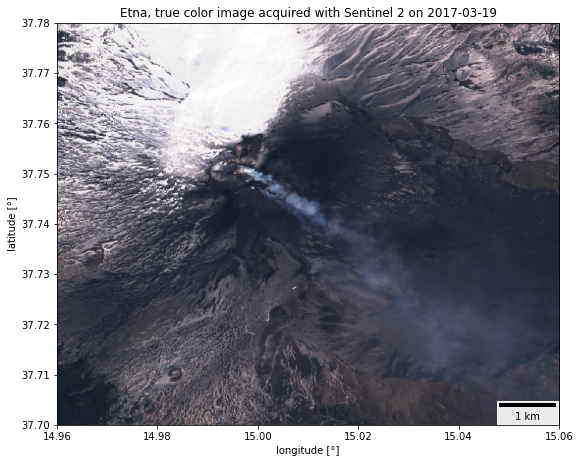

In [3]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt

def plot_image(image, bbox, factor=1):
    """
    Utility function for plotting RGB images.
    
    :param image: image to be plotted
    :type image: numpy array
    :param bbox: bounding box object, which will be used to set the 
     extent of the plot
    :type bbox: sentinelhub.common.bbox
    :param factor: factor
    :type factor: int
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    
    bbox_polygon = bbox.get_polygon()

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), extent=[
            bbox_polygon[0][0], bbox_polygon[2][0], 
            bbox_polygon[0][1], bbox_polygon[2][1]])
    else:
        plt.imshow(image, extent=[bbox_polygon[0][0], 
                                  bbox_polygon[2][0], 
                                  bbox_polygon[0][1], 
                                  bbox_polygon[2][1]])
    
    #Add axes' lables
    if bbox.crs == CRS.WGS84 :
        plt.xlabel('longitude [°]')
        plt.ylabel('latitude [°]')
    else:
        plt.xlabel('easting  [m]')
        plt.ylabel('northing [m]')
        
    #Add scalebar
    width = image.shape[1]
    height = image.shape[2]
    resx, resy = geo_utils.bbox_to_resolution(bbox, 
                                              width, 
                                              height) 
    scalebar = ScaleBar((width*resx)/(bbox_polygon[2][0]
                                      -bbox_polygon[0][0]), 
                        'm', 
                        location='lower right', 
                        box_alpha=0.9)
    plt.gca().add_artist(scalebar)

    
display_image = 4 
plot_image(true_color_img_s2[display_image], etna_bbox)
plt.title('Etna, true color image acquired with Sentinel 2 on '+ str(
            true_color_dates_s2[display_image].date()));
print()

This is how Etna looks like from space! This visualization is called a <b>true color composite</b> because the scene appears as it would be seen by a human observer (i.e. snow and clouds appear white, soil appears dark, etc.). To be honest, it is difficult to interpret this concrete image. We notice different white surfaces, which might be either snow, smoke or clouds. If we look more carefully we can notice a shadow on the right lower corner indicating that there is a mountain in the image. Knowing that this is Etna, we can recognize a crater and smoke fuming out of the crater. Lava is dark thus it is impossible to distinguish it from soil or see it through the smoke.

But we know lava is much hotter than soil. Could we make use of the lava's "hotness" to see it?

## 2 Some Background

### 2.1 Wien's Displacement Law
Every object, which is hotter than absolute zero (0° Kelvin), emits electromagnetic radiation - the hotter the object, the higher the frequency at which the most of radiation is emitted (i.e. the shorter the wavelength $\lambda$). This relationship is described by Wien's displacement law:

\begin{equation*}
\lambda_{max}=\frac{b}{T}
\end{equation*}

where:
 - $\lambda_{max}$ is λ, at which the blackbody with temperature $T$ emits the most of electromagnetic energy
 - $b = 2.9*10^{-3}$ is Wien's displacement constant
 - $T$ is temperature of the blackbody
 
 We will illustrate this in a figure below but before that let's talk about "satellite's bands".

### 2.2 Satellite's Bands
Another concept that we need to familiarize ourselves with is the concept of satellite bands. Sensors carried by satellites like Sentinel-2 or Landsat 8 can image our Earth in different parts of the electromagnetic spectrum. 
The light that we see as humans can generally be thought of as having three components or bands: red, blue and green. Remember the true color image from earlier? That is a representation of the images acquired in red, blue and green bands of the satellite. These bands roughly match our own human vision and the image therefore appears in the same way as it would be seen by a human observer in space. 
But satellites can see much more of the electromagnetic spectrum than we humans can. For example, Sentinel-2 is also observing the near infrared and shortwave infrared parts of the electromagnetic spectrum. These correspond to much longer wavelengths than the visible light. Below is a table of Sentinel-2's and Landsat 8 bands, their central wavelength and spatial resolutions.

In [4]:
from IPython.core.display import HTML

# Satellite Bands with their wavelengths   
# S2 bands, (band name, S2A central wavelength, S2A bandwidth, ...)
bands_s2 =[ ("B01", 442.7, 21, 442.2, 21, 60),
            ("B02", 492.4, 66, 492.1, 66, 10),
            ("B03", 559.8, 36, 559.0, 36, 10),
            ("B04", 664.6, 31, 664.9, 31, 10),
            ("B05", 704.1, 15, 703.8, 16, 20),
            ("B06", 740.5, 15, 739.1, 15, 20),
            ("B07", 782.8, 20, 779.7, 20, 20),
            ("B08", 832.8, 106, 832.9, 106, 10),
            ("B8a", 864.7, 21, 864.0, 22, 20),
            ("B09", 945.1, 20, 943.2, 21, 60),
            ("B10", 1373.5, 31, 1376.9, 30, 60),
            ("B11", 1613.7, 91, 1610.4, 94, 20),
            ("B12", 2202.4, 175, 2185.7, 185, 20)]

#L8 bands, (band name, min band wavelength, max band wavelength)
bands_l8 = [("B01", 435, 451, 30),
            ("B02", 452, 512, 30), 
            ("B03", 533, 590, 30),
            ("B04", 636, 673, 30), 
            ("B05", 851, 879, 30),
            ("B06", 1566, 1651, 30),
            ("B07", 2107, 2294, 30),
            ("B08", 503, 676, 15),
            ("B09", 1363, 1384, 30),
            ("B10", 10600, 11190, 100),
            ("B11", 11500, 12510, 100)]

display(HTML(
    '<h3>Sentinel-2</h3><table><tr><th>Band</th><th>Central wavelength [nm]</th><th>Spatial Resolution [m]</th></tr><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in (row[0],row[1],row[5]))) for row in bands_s2)
        )
 ))

display(HTML(
    '<h3>Landsat 8</h3><table><tr><th>Band</th><th>Central wavelength [nm]</th><th>Spatial Resolution [m]</th></tr><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in (row[0],(row[1]+row[2])/2,row[3] ))) for row in bands_l8)
        )
 ))

Band,Central wavelength [nm],Spatial Resolution [m]
B01,442.7,60
B02,492.4,10
B03,559.8,10
B04,664.6,10
B05,704.1,20
B06,740.5,20
B07,782.8,20
B08,832.8,10
B8a,864.7,20
B09,945.1,60


Band,Central wavelength [nm],Spatial Resolution [m]
B01,443.0,30
B02,482.0,30
B03,561.5,30
B04,654.5,30
B05,865.0,30
B06,1608.5,30
B07,2200.5,30
B08,589.5,15
B09,1373.5,30
B10,10895.0,100


By plotting radiation curves for objects with different temperatures we can present the "displacements" of their maximum. S2 and L8 bands can also be visualized so that their position in spectrum can be compared to radiation curves. 

In [5]:
# @hidden_cell
import scipy.constants as sc
import ipywidgets as widgets
from IPython.display import display, HTML

# Constants
h = sc.Planck
c = sc.speed_of_light
kb = sc.Boltzmann
e = np.exp(1)
b = sc.Wien

hc_kb = h*c/kb

def planck_law (w, T):
    #factor1 = 2 * h * c**2 / w**5
    factor1 = 2 * h * np.power(c,2) / np.power(w,5)
    factor2 = 1 / ( np.power(e,( hc_kb / (w*T))) - 1 )
    return factor1 * factor2

    
def wien_law (T):
    alfa_max = b / T
    return alfa_max


def draw_curve (ax, wavelengths, T, color):
    ax.plot(list(wavelengths), planck_law (wavelengths* 10**(-9), 
            T), color=color)
    xmax = wien_law (T) * 10**(9)
    ymax = planck_law (wien_law(T), T)
    if ax.get_xlim()[1] > xmax:
        ax.plot(xmax, ymax, 'o', color=color)
        ax.text(xmax*1.03, ymax*1.01, str(T-273) + "°C", fontsize=14, color=color)
            

def draw_spectrum (custom_temperature, draw_curves, draw_RGB, draw_s2, draw_l8):
    fig, ax = plt.subplots (2, 1, figsize=(16, 12))
    
    # Generate data
    wavelengths = np.linspace(100, 13000, 400) #(start, stop, number) in nm
    
    # Set some global characteristics of the plots
    ax[0].set_title("Overview plot")
    ax[1].set_title("Detailed plot for wavelengths up to 2500 nm")
    ax[1].set_xlim(0, 13000);
    ax[1].set_xlim(0, 2500);
    
    # The same thing will be drawn in all subplots but we set different limits 
    # for x axes for each subplot to achive "zoom in" effect.
    for a in ax: 
        if custom_temperature:
            draw_curve (a, wavelengths, custom_temperature + 273, '#ff1a1a')
            
        if draw_curves:
            for T in [6000, 5000, 4000, 3000, 1000, 300]:
                draw_curve (a, wavelengths, T + 273, '#000000')
                
        #add RGB
        if draw_RGB:
            a.axvspan(590, 750, facecolor='r', alpha=0.2)
            a.axvspan(495, 590, facecolor='g', alpha=0.2)
            a.axvspan(400, 495, facecolor='b', alpha=0.2)

        # add Sentinel 2 bands
        if draw_s2:
            for band in bands_s2:
                a.axvspan((band[1] - band[2]/2) , (band[1] + band[2]/2), 
                          facecolor='#2ca02c', alpha=0.4)

        # add Landsat 8 bands
        if draw_l8:
            for band in bands_l8[:]:
                a.axvspan( band[1], band[2], facecolor="#3366ff", alpha=0.4)

        a.set_xlabel('Wavelength [nm]')
        a.set_ylabel(r'Spectral radiance [W·sr$^\mathsf{-1}$·m$^\mathsf{-3}$]')

        
# Widgets
style = {'description_width': 'initial'}
text_temp = widgets.BoundedIntText(
    value=5500,
    min=-10,
    max=10000,
    step=1,
    description='Add red curve for temperature [°C]:',
    disabled=False,
    style=style
)

toggle_curves = widgets.Checkbox(
    value=True,
    description='Radiation Curves',
    disabled=False
)

toggle_s2 = widgets.Checkbox(
    value=False,
    description='S2 bands',
    disabled=False
)

toggle_l8 = widgets.Checkbox(
    value=False,
    description='L8 bands',
    disabled=False
)

toggle_RGB = widgets.Checkbox(
    value=True,
    description='Visible part of spectrum',
    disabled=False
)

# Make the plot interactive
widgets.interact(draw_spectrum, 
                 custom_temperature=text_temp, 
                 draw_curves=toggle_curves, 
                 draw_RGB=toggle_RGB, 
                 draw_s2=toggle_s2, 
                 draw_l8=toggle_l8); 

interactive(children=(BoundedIntText(value=5500, description='Add red curve for temperature [°C]:', max=10000,…

Both figures above show radiation curves of blackbodies at different temperatures (black) and visible part of the spectrum (blue, green and read colors in background). The curves are presentation of Planck's Law. Dots represent maximum of each curve. Note how curves with lower temperatures have maximum at longer wavelengths (= what Wien Displacement Law says). The Sun's temperature is approximately 5500 °C and its radiation has a peak around 500 nm, which corresponds to visible part of the spectrum. Whereas Earth's radiation peaks around 10000 nm, it does not emit visible light thus we cannot see it with naked eye unless it is illuminated by the Sun (or some other source of visible light).

#### 2.2.1 Play with the graph
1) Try to insert typical temperatures of some objects in the textbox and click outside of it. Try, e.g.:
- 10000 °C approx. temperature of Sirius, the brightest star
- 5500 °C approx. temperature of the Sun
- 450 °C - 1000 °C approx. temperature of lava right after eruption
- 200 °C temperature in the oven when the bread is baked
- 0 °C temperature at which water freezes 

The radiation curve for blackbody with the selected temperature will be added to the graph in red color. If needed turn off "Radiation curves" so that the graph limits will adjust to the red curve and observe how the maximum of the curve moves relative to wavelengths depending on the temperature. 
<br>
<br>
2) Checkboxes below can be used to turn off/on specific information. Try turning on/off S2 and L8 bands to see in which part of the spectrum satellites detect the radiation.
<br>
<br>
3) Try to turn off "Radiation Curves" and insert 700 °C (approx. temperature of lava) in the textbox. Turn on S2 and L8 bands. The first figure will adjust the limits of axes and it will be easier to observe where the maximum of radiated energy for 700 °C is relative to satellite bands.


Most of the objects on Earth surface can be imaged by Sentinel-2 and Landsat 8 only because they reflect Sun's radiation, which has a peak in visible part of electromagnetic spectrum. Would we still be able to see anything in the satellite images if we turned the Sun off (or if the satellites captured images by night)?

Well, very little but yes, we would still see "hot-enough" objects on Earth surface, which emit radiation with "short-enough" wavelengths, which can be captured by the bands sensitive to the longest wavelengths. In case of Sentinel-2 such bends are 11 and 12 and for Landsat 8 such bands are 6, 7, 10 and 11. Fortunately for us, lava erupted from Etna in 2017 was "hot-enough".

## 3 Visualizing Etna's Eruption

### 3.1 Sentinel-2 Images
To utilize these concepts, we will create a visualization based on data acquired in infra-red part of electromagnetic spectrum (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). We will use:
- Band 04 (B04), which measures radiation of electromagnetic waves with wavelengths around 665 nm
- Band 11 (B11), which measures radiation of electromagnetic waves with wavelengths around 1610 nm 
- Band 12 (B12), which measures radiation of electromagnetic waves with wavelengths around 2190 nm

To visualize these data, we will use red color for image acquired with B12, green color for image acquired with B11 and blue color for image acquired with B04. Let check how that looks like:

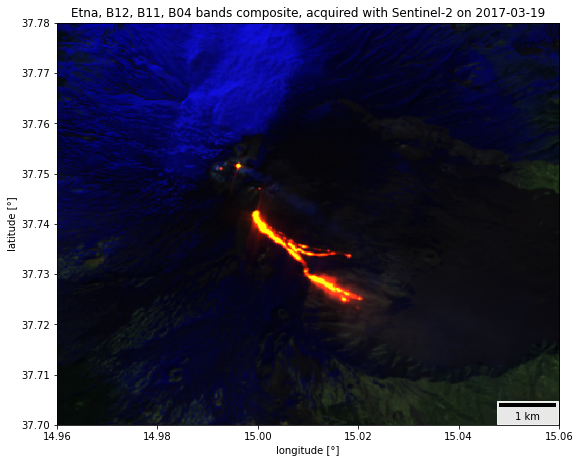

In [6]:
bands_request_s2 = WmsRequest(data_folder='data',
                               data_collection=DataCollection.SENTINEL2_L1C,
                               layer='BANDS-S2-L1C',
                               bbox=etna_bbox,
                               time=('2017-02-27','2017-04-18'),
                               width=512,
                               image_format=MimeType.TIFF_d32f,
                               maxcc=0.8,
                               config=config,
                               custom_url_params={
                                   CustomUrlParam.SHOWLOGO: False})

bands_img_s2 = bands_request_s2.get_data(save_data=True)
bands_dates_s2 = bands_request_s2.get_dates()

#Note: Numbers 12, 11, 3 do not indicate bands but indexes of bands_img_s2 array.
plot_image(bands_img_s2[display_image][:, :, [12, 11, 3]], 
           etna_bbox, 2.5) 
plt.title('Etna, B12, B11, B04 bands composite, acquired with Sentinel-2 \
on '+ str(bands_dates_s2[display_image].date()))
print()

This is a composite of bands B12, B11 and B04. The image is much different from true color image, here we can easily distinguish snow from smoke. More interestingly hot lava flow can now be nicely observed. It appears red and yellow due to high values in B12 (red color) and in B11 (green color). However, in nature lava would (still) be black (dark) as we saw in true color image.

Now that we know how to visualize data in a useful way, let's put all images acquired during Etna's eruption together to gain some understanding of the dynamic of the phenomenon. To have a good tool to browse through all these images we will prepare a function "visualize_images", which can be combined with preprepared <a href="https://ipywidgets.readthedocs.io/en/stable/">ipython widgets</a>.

In [7]:
print()
import ipywidgets as widgets
from IPython.display import display, HTML

def visualize_images(images, dates, i, R, G, B):
    """
    This function will draw an image selected from the list of "images"
    for a given "date". It is linked to dropdown list from which user 
    can select image to be drawn.

    :param images: satellite images, each array corresponds to a single
     image and has shape [height, width, channels]. 
    :type images: list of numpy arrays
    :param dates: dates of acquisition of satellite images 
    :type dates: list of datetime
    :param i: value of current selection in the widget
    :type i: datetime
    :param R: indexs, which represent the image of a channel, which 
     will be drawn with red color
    :type R: int
    :param G: indexs, which represent the image of a channel, which 
     will be drawn with green color
    :type G: int
    :param B: indexs, which represent the image of a channel, which 
     will be drawn with blue color
    :type B: int
    """

    plot_image(images[dates.index(i)][:, :, [R, G, B]],etna_bbox, 2.5)


dropdown_date_s2 = widgets.Dropdown(
                                options=bands_dates_s2,
                                value=bands_dates_s2[4],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(visualize_images, images=widgets.fixed(bands_img_s2), 
                 dates=widgets.fixed(bands_dates_s2), 
                 i=dropdown_date_s2, R=widgets.fixed(12), 
                 G=widgets.fixed(11), B=widgets.fixed(3));

interactive(children=(Dropdown(description='Date:', index=4, options=(datetime.datetime(2017, 2, 27, 9, 56, 13…

Quite nice, right? We can see the lava first flowed towards south-esat and then it turned to south-west. Image acquired on February 27th 2017 is very cloudy but still interesting since it tells us that some activity in Etna's crater had started in February already. 


### 3.2 Landsat 8 Images
So far we have used images acquired from Sentinel-2 satellite. We could check if there are any available (and cloudless) images from other satellites, which could reveal additional information about the event. Landsat 8, which has similar sensors as Sentinel-2 on board, seems the most promising choice. Let's download the data and display one of the true color images:

We downloaded 6 images, each one acquired on a different date (i.e.time series). 
Single image is of type <class 'numpy.ndarray'> and has a shape (516, 512, 4). First two dimensions indicate the size of downloaded image in pixels and the last is a number of downloaded bands: red, green blue.



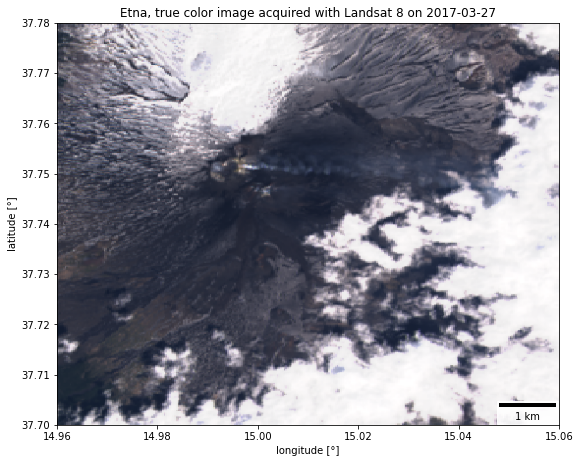

In [8]:
true_color_request_l8 = WmsRequest(
                            data_folder='data',
                            data_collection=DataCollection.LANDSAT8,
                            layer='TRUE-COLOR-L8',
                            bbox=etna_bbox,
                            time=('2017-02-25','2017-04-18'),
                            width=512,
                            maxcc=0.8,
                            config=config,
                            custom_url_params={
                            CustomUrlParam.SHOWLOGO: False})

true_color_img_l8 = true_color_request_l8.get_data(save_data=True)
true_color_dates_l8 = true_color_request_l8.get_dates()

# Display some basic information about downloaded data
print('We downloaded %d images, each one acquired on a different date (i.e.\
time series). ' % len(true_color_img_l8))
print('Single image is of type {} and has a shape {}. First two dimensions \
indicate the size of downloaded image in pixels and the last is a number of \
downloaded bands: red, green blue.'.format(type(
    true_color_img_l8[-1]), true_color_img_l8[-1].shape))

# Diplay ture color image
display_image = -3 
plot_image(true_color_img_l8[display_image],etna_bbox)
plt.title('Etna, true color image acquired with Landsat 8 on '+ str(
    true_color_dates_l8[display_image].date()));
print()

In [9]:
bands_request_l8 = WmsRequest(data_folder='data',
                              data_collection=DataCollection.LANDSAT8,
                              layer='BANDS-L8',
                              bbox=etna_bbox,
                              time=('2017-02-25','2017-04-18'),
                              width=512,
                              maxcc=0.7,
                              image_format=MimeType.TIFF_d32f,
                              config=config,
                              custom_url_params={
                                  CustomUrlParam.SHOWLOGO: False})

bands_img_l8 = bands_request_l8.get_data(save_data=True)
bands_dates_l8 = bands_request_l8.get_dates()


print()
dropdown_date_l8 = widgets.Dropdown(
                                options=bands_dates_l8,
                                value=bands_dates_l8[0],
                                description='Date:',
                                disabled=False,
                                )


#Note: Numbers 6, 5, 7 do not indicate bands but indexes of bands_img_l8 array.
widgets.interact(visualize_images, images=widgets.fixed(bands_img_l8), 
                 dates=widgets.fixed(bands_dates_l8), i=dropdown_date_l8, 
                 R=widgets.fixed(6), G=widgets.fixed(5), 
                 B=widgets.fixed(7));

interactive(children=(Dropdown(description='Date:', options=(datetime.datetime(2017, 3, 2, 9, 42, 3), datetime…

Observing Landsat images we see that lava flow changed its direction more than once. It flowed south-west on March 2nd, than it south-east on March 18th and than south-west again on march 27th. The image acquired April 12th is cloudy and we can not conclude anything about direction of lava flow. 
The image acquired on March 2nd does not cover the whole area of interest, since it lies on the edge of the area that satellite captured on that date. 

### 3.3 Combination of Sentinel and Landsat images

We gathered some information from Sentinel-2 images and some from Landsat 8. Let's visualize all together now:

In [10]:
# Show images from Sentinel 2(s2) and landsat 8(l8) sorted by date of 
# acquisition
# Extract only the bands that we need for visualization
RGB_s2 = [image_on_date[:, :, [12, 11, 3]] for image_on_date in bands_img_s2]
RGB_l8 = [image_on_date[:, :, [6, 5, 7]] for image_on_date in bands_img_l8]

# Add information about data source (s2 vs l8)
data_source = []
[data_source.append("S2") for s2_image in RGB_s2];
[data_source.append("L8") for l8_image in RGB_l8];

#Create list of tuples (image, date, data source) and sort the list by dates
both_satellites = []
for index, image in enumerate([RGB_s2 + RGB_l8][0]):
    both_satellites.append((image,
                            [bands_dates_s2 + bands_dates_l8][0][index], 
                            data_source[index]))
both_satellites_sorted = sorted(both_satellites, key=lambda tup: tup[1])

#Re-arange into seperate lists, which are needed for vizualisation
images_both = [image_date_ds[0] for image_date_ds in both_satellites_sorted]
dates_sources_both = [str(image_date_ds[1])[:-9] + ", Satellite:"+ image_date_ds[2] 
                      for image_date_ds in both_satellites_sorted]

# Visualization of time series
print()
dropdown_date_both = widgets.Dropdown(
                                options=dates_sources_both,
                                value=dates_sources_both[0],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(visualize_images, images=widgets.fixed(images_both), 
                 dates=widgets.fixed(dates_sources_both), i=dropdown_date_both, 
                 R=widgets.fixed(0), G=widgets.fixed(1), 
                 B=widgets.fixed(2));

interactive(children=(Dropdown(description='Date:', options=('2017-02-27, Satellite:S2', '2017-03-02, Satellit…

Combining images from two different satellites gave us a time series, where we have an image every three or four days. The biggest gapes are between March 19th and March 26th. As already noticed by analyzing Landsat images lava changed the direction several times. We still can not get much information from cloudy images acquired on February 27th and April 12th. But combining images from both satellites provided us a cloudless images closer to those dates.  
When combining and interpreting images like this, we shall keep in mind the differences between sensors on both satellites:
- they have different middle wavelengths of channels we used for visualization thus colors can not be accurately compared,
- they have different spatial resolution thus the surfaces can not be accurately compared.

## 4 Other Etna Eruptions

Etna's eruptions in 2017 was of course not the only one. We searched through news about recent eruptions and checked if we can spot them in any of the satellite images. This is what we've found:

1) Etna, image from Landsat 5 on November 24th 2006:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07" target="_blank">
 <img src="images/2006-11-24, Landsat 5 ESA, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 5 on November 24th 2006 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

First of all, we notice yellowish-red lava and a strange rather unnatural pattern in a shape of diagonal lines. The lines are a consequence of an anomaly of the sensor. It is a known anomaly, so called "oversaturation" https://landsat.usgs.gov/oversaturation, which happens because the intensity of signal is much stronger than what the sensor can capture (the same effect can be observed on a photography of a very bright object, e.g. sun taken with a camera or a phone). 
We see dark smoke fuming in south east direction. Its dark shadow indicates that it must have contained a lot of ash and that smoke pillar must have been rather high. These observations can be checked by comparison to photos of the event taken in the field https://www.youtube.com/watch?v=zNfrbnRaY0g. 

2) Etna, image from Landsat 8 on December 3rd 2015:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07" target="_blank">
 <img src="images/2015-12-03, Landsat 8 USGS, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 8 on December 3rd 2015 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

3) First (left) and the most recent (right) Etna eruptions, which can be found on satellite images in EO Browser:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.75307&lng=15.01041&zoom=13&time=1984-05-19&preset=CUSTOM&atmFilter=none&gainOverride=1&gammaOverride=1&redRangeOverride=[0,1]&greenRangeOverride=[0,1]&blueRangeOverride=[0,1]&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07" target="_blank">
 <img src="images/1984-05-19, Landsat 5 ESA, Custom script.jpg" alt="Drawing" style="width: 478px;"/>
</a>
</td>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74371&lng=15.00406&zoom=13&time=2018-12-26&preset=CUSTOM&datasource=Sentinel-2%20L1C&layers=B12,B11,B04&evalscript=cmV0dXJuIFtCMTIqMi41LEIxMSoyLjUsQjA0KjIuNV07" target="_blank">
 <img src="images/2018-12-26, Sentinel-2A L1C, Custom script.jpg" alt="Drawing" style="width: 450px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 5 on May 19th 1984 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.75307&lng=15.01041&zoom=13&time=1984-05-19&preset=CUSTOM&atmFilter=none&gainOverride=1&gammaOverride=1&redRangeOverride=[0,1]&greenRangeOverride=[0,1]&blueRangeOverride=[0,1]&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07">EO Browser link</a>). 
</td>
<td style="text-align:left"> Etna, image from Sentinel-2 on December 26th 2018 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74371&lng=15.00406&zoom=13&time=2018-12-26&preset=CUSTOM&datasource=Sentinel-2%20L1C&layers=B12,B11,B04&evalscript=cmV0dXJuIFtCMTIqMi41LEIxMSoyLjUsQjA0KjIuNV07">EO Browser link</a>). 
</td>
</tr>
</table>

## 5 Conclusions

In this exercise we observed the eruption of the biggest European volcano, Etna. We used and visually analyzed images acquired from Sentinel-2 and Landsat 8 satellites. True color image was difficult to interpret thus we combined images acquired in other parts of electromagnetic spectrum into composite image. This enabled us to distinguish lava from soil and snow from smoke and clouds. Combining images from two different satellites gave us more information about the dynamic of the process but interpretation has to include the differences between the sensors.

We also checked satellite images of two previous eruptions reported in news. Image acquired with Landsat 5 was influenced by sensor anomaly called "oversaturation". Sensor anomalies must be considered when interpreting satellite images. All known anomalies appearing in Landsat images are collected and described <a href="https://www.usgs.gov/core-science-systems/nli/landsat/landsat-known-issues">here</a>. For Sentinel-2 satellite one can find similar anomalies described in <a href="https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library">Data Quality Reports</a>.

Did you find this exercise interesting? Why do not you try to find a satellite image of another volcano's eruption? Browse through satellite images with <a href="https://apps.sentinel-hub.com/eo-browser/">EO Browser</a> and if you find an interesting image, share its link or send it to us and we might include it here.


## References and Other Resources to Check

- Volcanoes by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Volcanoes
- Earth's Most Active Volcanoes on Satellite Watch by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Earth_s_most_active_volcanoes_on_satellite_watch
- Volcanic Cloud Monitoring: https://volcano.ssec.wisc.edu/
- Sensing Remote Volcanoes by NASA: https://earthdata.nasa.gov/user-resources/sensing-our-planet/sensing-remote-volcanoes
- Known anomalies of Landsat sensors: https://www.usgs.gov/core-science-systems/nli/landsat/landsat-known-issues
- Kilauea Volcano lava flows 2018: https://www.flickr.com/photos/pierre_markuse/sets/72157691471237670/
- An Eruption through Several Spectrums: http://blog.digitalglobe.com/technologies/an-eruption-through-several-spectrums/
- Sentinel 2 Document Library (Quality Assurance reports): https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library